In [36]:
import numpy as np
import pandas as pd
import datetime
import glob
import matplotlib.pyplot as plt
%matplotlib inline

### Unpack drawings

In [147]:
# Copyright 2017 Google Inc.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
# https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import struct
from struct import unpack


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

### Create the dataframe with the selected concepts

In [195]:
concepts = {
    'animals':[
        'cat',
        'dog',
        'fish',
        'whale',
        'dolphin',
        'spider',
        'crocodile',
        'elephant',
        'snake',
        'rabbit'
    ],
    'body':[
        'skull',
        'arm',
        'beard',
        'brain',
        'ear',
        'elbow',
        'eye',
        'face',
        'finger',
        'foot',
        'knee',
        'leg'
    ],
    'sport':[
        
    ],
    'music':[
        'cello',
        'clarinet',
        'guitar',
        'harp',
        'piano',
        'saxophone',
        'violin'  
    ],
    'nature':[
        
    ],
    'food':[
        
    ]
}

selected_concepts = [
    'cat',
    'face',
    'dog',
    'apple'
]

selected_concepts = concepts['animals']

In [196]:
drawings = []

for concept in selected_concepts:
    for drawing in unpack_drawings('binary/' + concept + '.bin'):
        drawing['concept'] = concept
        drawings.append(drawing)

df = pd.DataFrame(drawings)

### Clean the dataframe

In [197]:
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['countrycode'] = df['countrycode'].str.decode('utf-8')

In [198]:
df.head()

,concept,countrycode,image,key_id,recognized,timestamp,date
0,cat,VE,"[((130, 113, 99, 109, 76, 64, 55, 48, 48, 51, ...",5201136883597312,1,1488497110,2017-03-02 23:25:10
1,cat,BR,"[((222, 196, 176, 173, 179, 191, 233, 251, 255...",4647694628814848,1,1490553834,2017-03-26 18:43:54
2,cat,RO,"[((65, 71, 74, 68, 70, 65, 65), (64, 67, 72, 7...",6411036099870720,1,1489829768,2017-03-18 09:36:08
3,cat,US,"[((148, 127, 119, 80, 60, 53, 48, 49, 56, 67, ...",6196755135725568,1,1485360351,2017-01-25 16:05:51
4,cat,ID,"[((91, 77, 74, 75, 90, 116, 134, 148, 164, 165...",4597292839469056,1,1485657736,2017-01-29 02:42:16


### Percentage of unrecognized drawings by country

In [205]:
(df[df['concept'] == 'spider']
 .groupby('countrycode')
 .filter(lambda x: len(x) > 1000)
 .groupby('countrycode')
 .apply(lambda x: x[x['recognized'] == 0]['recognized'].count() / len(x) * 100)
 .sort_values(ascending=False))

countrycode
SA    19.612278
HU    15.301160
TH    13.700616
RO    13.440860
UA    11.928934
SK    11.643836
AE    11.588642
PH    11.162433
IN    10.875332
US    10.794724
CZ    10.740531
IE    10.682493
ID    10.549695
IT    10.512289
VN    10.254735
RU    10.125142
CA    10.052554
FI     9.788287
PL     9.662522
SE     9.289466
NL     9.276520
GB     9.105310
MY     8.793265
NO     8.560677
AU     8.469510
FR     7.754670
BR     7.508343
JP     6.511254
DE     6.488847
TW     5.295950
KR     4.333576
dtype: float64

### What is the most unrecognized drawing?

In [200]:
(df.groupby('concept')
 .apply(lambda x: x[x['recognized'] == 0]['recognized'].count() / len(x) * 100)
 .sort_values(ascending=False))

concept
elephant     17.313675
crocodile    16.823000
cat          16.372299
rabbit       14.144686
spider       10.304277
dolphin       9.273680
whale         6.369848
dog           5.832057
fish          5.762206
snake         5.733073
dtype: float64

### Which country produces the most detailed drawings?

In [257]:
# The more strokes a drawing has, the more detailed it is
(df.groupby('countrycode')
 .apply(lambda x: pd.Series([len(d) for d in x['image']]).mean())
 .sort_values(ascending=False)).head()

countrycode
BF    20.000000
AF    10.454545
BJ     9.000000
TJ     8.666667
MM     8.493671
dtype: float64

### Comparison between US and Korea

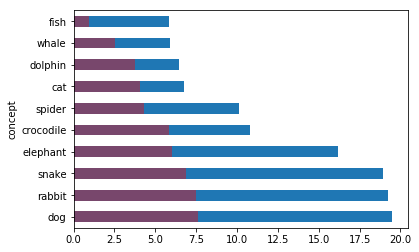

In [242]:
ax = (df[df['countrycode'] == 'US'].groupby('concept')
 .apply(lambda x: x[x['recognized'] == 0]['recognized'].count() / len(x) * 100)
 .sort_values(ascending=False)).plot(kind='barh')
(df[df['countrycode'] == 'KR'].groupby('concept')
 .apply(lambda x: x[x['recognized'] == 0]['recognized'].count() / len(x) * 100)
 .sort_values(ascending=False)).plot(kind='barh', ax=ax, alpha=0.4, color='red')

### Number of drawings by country

In [169]:
(df[df['concept'] == 'crocodile']
 .groupby('countrycode')
 .filter(lambda x: x['countrycode'].count() > 1000)['countrycode']
 .value_counts())

US    54278
GB     9145
CA     4665
DE     4276
AU     3318
RU     3138
CZ     2497
BR     2421
SE     2329
FI     2136
IT     2024
PL     1938
FR     1865
TH     1814
HU     1669
KR     1639
PH     1605
NL     1568
SA     1377
ID     1101
SK     1024
Name: countrycode, dtype: int64

### Average number of lines for the current drawing

In [224]:
# Average number of lines of the recognized drawings
df[df['recognized'] == 1]['image'].apply(lambda x: len(x)).mean()

5.8416910013637109

In [225]:
# Average number of lines of the unrecognized drawings
df[df['recognized'] == 0]['image'].apply(lambda x: len(x)).mean()

9.8970548897924253

### Average complexity of the lines for the current drawing

In [88]:
# Average complexity of the lines in the recognized drawings
(df[df['recognized'] == 1]
 ['image'].apply(lambda x: pd.Series([len(line[0]) for line in x]).mean())
 .mean())

6.6681544599044971

In [89]:
# Average complexity of the lines in the unrecognized drawings
(df[df['recognized'] == 0]
 ['image'].apply(lambda x: pd.Series([len(line[0]) for line in x]).mean())
 .mean())

8.2199579457983489

### Drawing with the lowest number of lines

In [234]:
df['image'].apply(lambda x: len(x)).idxmin()

451

### Evolution of the percentage of unrecognized drawings

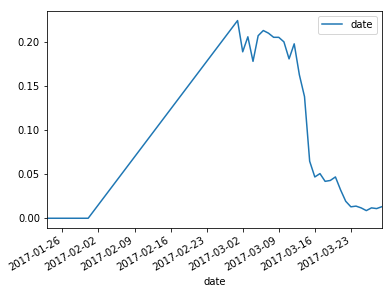

In [100]:
ax = (df.groupby(by=df['date'].dt.date)
      .apply(lambda x: x[x['recognized'] == 0].count() / len(x))
      .plot(y='date'))
fig = plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')